In [ ]:
from IPython.display import clear_output
! pip install latentis
# ! pip install bayesian-optimization
! pip install cvxopt
! pip install qpsolvers==3.4.0
# ! pip install accelerate==0.20.3 -U
! pip install git+https://github.com/simonzhang00/ripser-plusplus.git
! pip install git+https://github.com/IlyaTrofimov/RTD.git
clear_output()
!pip install -U lightautoml
!git clone https://github.com/mklabunde/resi.git
!pip install loguru
!pip install git+https://github.com/KhrulkovV/geometry-score.git
!pip install git+https://github.com/xgfs/imd.git
!pip install gudhi
!pip install --upgrade numpy catboost

clear_output()

In [ ]:
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import warnings
import torch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pickle
import sys
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from lightgbm import LGBMClassifier


sys.path.append('/content/resi/')
warnings.filterwarnings("ignore")
from repsim.measures import ALL_MEASURES
from repsim.measures import FUNCTIONAL_SIMILARITY_MEASURES
import rtd
from rtd.barcodes import h1sum, calc_embed_dist
from qpsolvers import solve_qp
warnings.filterwarnings("ignore")


from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

device = torch.device('cuda')

2025-04-11 09:44:32.698 | INFO     | repsim.measures.rtd:__init__:56 - RTD will use cuda devices to compute barcodes. It is not possible to specify which GPU directly. Use the CUDA_VISIBLE_DEVICES environment variable to specify which GPU to use.
2025-04-11 09:44:32.699 | INFO     | repsim.measures.rtd:__init__:56 - RTD will use cuda devices to compute barcodes. It is not possible to specify which GPU directly. Use the CUDA_VISIBLE_DEVICES environment variable to specify which GPU to use.


In [ ]:
from latentis import transform
from latentis.transform.dim_matcher import ZeroPadding
# from latentis.transform.orthogonal import SVDEstimator
from latentis.transform.translate.aligner import Translator, MatrixAligner, Procrustes
from latentis.transform.translate.functional import sgd_affine_align_state, svd_align_state

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Функции

In [ ]:
def save_res(dct, path):
  with open(path, 'wb') as handle:
      pickle.dump(dct, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def load_res(path):
  try:
    with open(path, 'rb') as handle:
      results = pickle.load(handle)
  except:
    results = {}

  return results

In [ ]:
def weight_embeds(tmp_emb, weights):
  final_embeds_train = tmp_emb[0][0].copy()
  final_embeds_test = tmp_emb[0][1].copy()

  # Применяем веса к копиям
  final_embeds_train.iloc[:, :256] = final_embeds_train.iloc[:, :256] * weights[0]
  final_embeds_test.iloc[:, :256] = final_embeds_test.iloc[:, :256] * weights[0]

  # Суммируем взвешенные эмбеддинги
  for i, (train, test) in enumerate(tmp_emb[1:], start=1):
      final_embeds_train.iloc[:, :256] += train.iloc[:, :256] * weights[i]
      final_embeds_test.iloc[:, :256] += test.iloc[:, :256] * weights[i]

  return final_embeds_train, final_embeds_test

In [ ]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 300
TARGET_NAME = 'target'
roles = {
    'target': TARGET_NAME,
    'drop': ['client_id']
}
task = Task('multiclass', metric='crossentropy')


def calc_accuracy_of_embeds(final_embeds_train, final_embeds_test):
  # Обучаем и оцениваем на первом наборе эмбеддингов
  automl = TabularAutoML(
      task=task,
      timeout=TIMEOUT,
      cpu_limit=N_THREADS,
      reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
  )

  # Обучаем модель и получаем out-of-fold предсказания
  out_of_fold_predictions = automl.fit_predict(final_embeds_train, roles=roles, verbose=-1000).data

  # Предсказания на тесте
  y_proba = automl.predict(final_embeds_test).data
  y_pred = y_proba.argmax(axis=1)  # Выбираем класс с максимальной вероятностью



  # Метрики для многоклассовой классификации
  metrics = {
      "Accuracy": accuracy_score,
      "F1 Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
      "ROC-AUC": lambda y_true, y_proba: roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
  }

  y_true = final_embeds_test[TARGET_NAME].values

  all_metrics = {
      metric_name: metric_func(y_true, y_pred if metric_name != "ROC-AUC" else y_proba)
      for metric_name, metric_func in metrics.items()
  }

  return all_metrics

# Смотрим менется ли качество среднего при переводе в одно пространство, ухуджает ли оно индивидуальные качсевта

## Расчет

In [ ]:
# берем для примера 6 наборов эмбедов
from tqdm import tqdm

embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    embeds.append((train, test))

100%|██████████| 102/102 [02:14<00:00,  1.32s/it]


In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/latentis_individual_and_mean.pkl'
results = load_res(PATH)
n = 6

In [ ]:
%%time
for i in range(0, len(embeds), n):

  results[i] = {}
  tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+n]]

  #приводим все в пространство первого набора
  base_space = torch.tensor(tmp_emb[0][0].iloc[:,:256].values, device = device)

  results[i]['individual_metrics'] = {}
  for j, (cur_train, cur_test) in enumerate(tmp_emb):
    translator_proc = Procrustes()
    cur_tr = torch.tensor(cur_train.iloc[:,:256].values, device = device)
    cur_ts = torch.tensor(cur_test.iloc[:,:256].values, device = device)

    translator_proc.fit(x=cur_tr, y=base_space)
    transformed_train = translator_proc(cur_tr)['x']
    transformed_test = translator_proc(cur_ts)['x']

    cur_train.iloc[:,:256] = transformed_train.cpu().numpy()
    cur_test.iloc[:,:256] = transformed_test.cpu().numpy()


    metrics = calc_accuracy_of_embeds(cur_train, cur_test)
    results[i]['individual_metrics'][j] = metrics




  unif_weights = np.ones(n)/n
  mean_train, mean_test = weight_embeds(tmp_emb, unif_weights)

  metrs = calc_accuracy_of_embeds(mean_train, mean_test)
  results[i]['mean_metrics'] = metrs
  save_res(results, PATH)

  clear_output()
  print(f'Эксперимент {i}')
  print(results[i])

Эксперимент 96
{'individual_metrics': {0: {'Accuracy': 0.42716666666666664, 'F1 Score': 0.41953707342644025, 'ROC-AUC': 0.7013303632096027}, 1: {'Accuracy': 0.30233333333333334, 'F1 Score': 0.2868157962333604, 'ROC-AUC': 0.5665032030238707}, 2: {'Accuracy': 0.47633333333333333, 'F1 Score': 0.46734698439168465, 'ROC-AUC': 0.7413198796875423}, 3: {'Accuracy': 0.43883333333333335, 'F1 Score': 0.42836096066136575, 'ROC-AUC': 0.7151006815891956}, 4: {'Accuracy': 0.38216666666666665, 'F1 Score': 0.3654358726481725, 'ROC-AUC': 0.6531576495981573}, 5: {'Accuracy': 0.43483333333333335, 'F1 Score': 0.42137363443490844, 'ROC-AUC': 0.7102833811291622}}, 'mean_metrics': {'Accuracy': 0.4855, 'F1 Score': 0.47753067085688705, 'ROC-AUC': 0.7531550557332551}}
CPU times: user 17h 13min 2s, sys: 1h 19min 18s, total: 18h 32min 21s
Wall time: 6h 5min 29s


In [ ]:
from google.colab import runtime
runtime.unassign()

## Результаты

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/latentis_individual_and_mean.pkl'
results = load_res(PATH)

In [ ]:
metr = "Accuracy"

### Портится ли индивидуальное качество эмбеддингов?

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/individual_accuracy.pkl'
individual_accuracy = load_res(PATH)
ind_acc = np.array([i[metr] for i in individual_accuracy.values()])

In [ ]:
new_individ_accuracy = np.array([value['individual_metrics'][j][metr] for key, value in results.items() for j in range(6)])

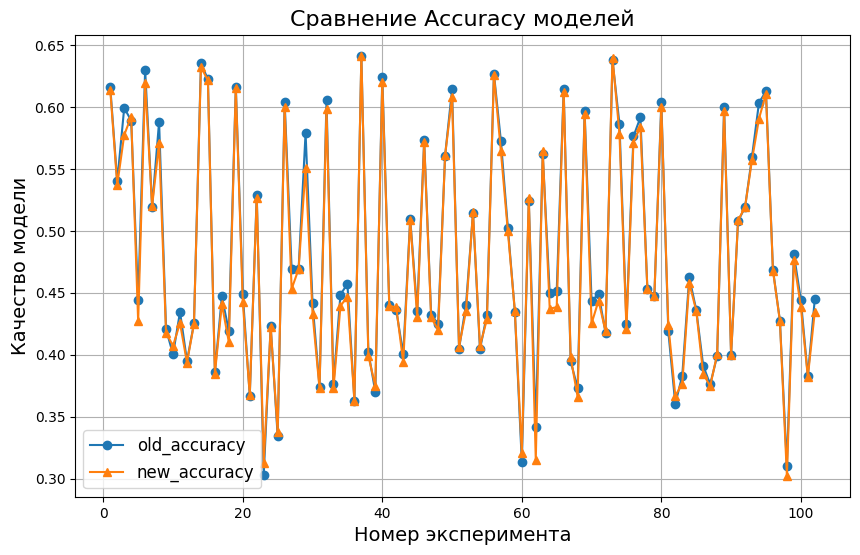

In [ ]:
experiments = np.arange(1, len(new_individ_accuracy) + 1)
plt.figure(figsize=(10, 6))


plt.plot(experiments, ind_acc, marker='o', label='old_accuracy')
plt.plot(experiments, new_individ_accuracy, marker='^', label='new_accuracy')
# plt.plot(experiments, concat_metrs, marker='^', label='concat')

plt.title(f'Сравнение {metr} моделей', fontsize=16)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.ylabel('Качество модели', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)

# Показать график
plt.show()

In [ ]:
diff = (new_individ_accuracy - ind_acc) / ind_acc
row = {
    'Mean (%)': diff.mean() * 100,      # Относительное изменение в %
    'Std (%)': diff.std() * 100,         # Стандартное отклонение в %
    'Better (%)': (new_individ_accuracy > ind_acc).mean() * 100  # Процент случаев
}

# Создание и вывод таблицы
df = pd.DataFrame(row, index = [0])
df

,Mean (%),Std (%),Better (%)
0,-0.747595,1.461358,26.470588


Качество немного ухудшилось, но не критично. \
Если это компенсируется тем, что среднее стало лучше, то не страшно

### Улучается ли качество среднего?

In [ ]:
new_mean = np.array([i['mean_metrics'][metr] for i in results.values()])

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/mean_perfomance.pickle'
old_mean = load_res(PATH)
old_mean = np.array([i[metr] for i in old_mean.values()])

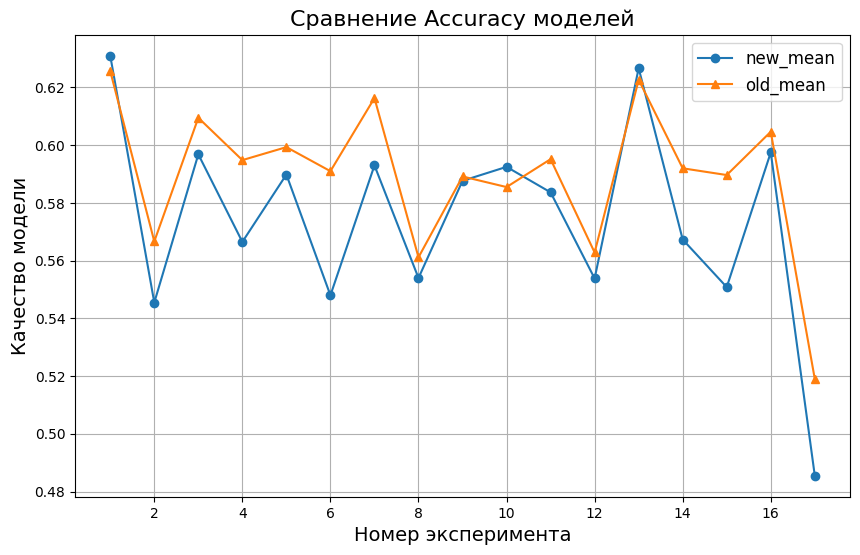

In [ ]:
experiments = np.arange(1, len(new_mean) + 1)
plt.figure(figsize=(10, 6))


plt.plot(experiments, new_mean, marker='o', label='new_mean')
plt.plot(experiments, old_mean, marker='^', label='old_mean')

plt.title(f'Сравнение {metr} моделей', fontsize=16)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.ylabel('Качество модели', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)

# Показать график
plt.show()

In [ ]:
diff = (new_mean - old_mean) / old_mean
row = {
    'Mean (%)': diff.mean() * 100,      # Относительное изменение в %
    'Std (%)': diff.std() * 100,         # Стандартное отклонение в %
    'Better (%)': (new_mean > old_mean).mean() * 100  # Процент случаев
}

# Создание и вывод таблицы
df = pd.DataFrame(row, index = [0])
df

,Mean (%),Std (%),Better (%)
0,-2.587548,2.558437,17.647059


Попробоуем другую метрику

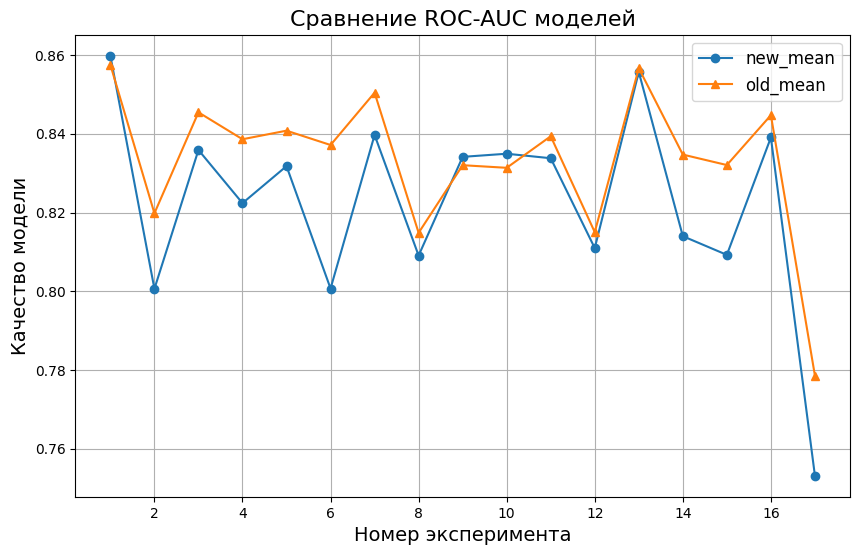

In [ ]:
metr = 'ROC-AUC'

new_mean = np.array([i['mean_metrics'][metr] for i in results.values()])
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/mean_perfomance.pickle'
old_mean = load_res(PATH)
old_mean = np.array([i[metr] for i in old_mean.values()])

experiments = np.arange(1, len(new_mean) + 1)
plt.figure(figsize=(10, 6))


plt.plot(experiments, new_mean, marker='o', label='new_mean')
plt.plot(experiments, old_mean, marker='^', label='old_mean')

plt.title(f'Сравнение {metr} моделей', fontsize=16)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.ylabel('Качество модели', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)

# Показать график
plt.show()

Среднее стало хуже

# Жадный алгоритм

In [ ]:
def selection_of_first(embeds_train):
  """
  Выбирает первого кандидата в комбинацию
  """
  pass
  # return first_emb, idx_frst

def get_best_candidate(combination, candidates):
  """
  Выбирает из candidates того, кто дает наибольший прирост информации
  """
  pass
  #return cand_emb, idx_cand

def update_combination(combination, new_candidate):
  """
  Добавляет нового кандидата в комбинацию
  """
  pass
  #return updated_combination

In [ ]:
embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    embeds.append((train, test))

100%|██████████| 102/102 [06:28<00:00,  3.81s/it]


In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/individual_accuracy.pkl'
ind_acc = load_res(PATH)
ind_acc = np.array([value['Accuracy'] for value in ind_acc.values()])

In [ ]:
def rankme(
    tensor,
    epsilon = 1e-12,
):

  s = np.linalg.svd(tensor, compute_uv=False)
  p_ks = s / np.sum(s + epsilon) + epsilon
  return np.exp(-np.sum(p_ks * np.log(p_ks)))

In [ ]:
def allign(tmp_emb, idx_base):
  #приводим все в пространство idx_base набора
  base_space = torch.tensor(tmp_emb[idx_base][0].iloc[:,:256].values, device = device)

  for j, (cur_train, cur_test) in enumerate(tmp_emb):
    translator_proc = Procrustes()
    cur_tr = torch.tensor(cur_train.iloc[:,:256].values, device = device)
    cur_ts = torch.tensor(cur_test.iloc[:,:256].values, device = device)

    translator_proc.fit(x=cur_tr, y=base_space)
    transformed_train = translator_proc(cur_tr)['x']
    transformed_test = translator_proc(cur_ts)['x']

    cur_train.iloc[:,:256] = transformed_train.cpu().numpy()
    cur_test.iloc[:,:256] = transformed_test.cpu().numpy()

In [ ]:
# def selection_of_first(embeddings, cur_ind_acc):
#   """
#   Выбирает первого кандидата в комбинацию
#   (пока читерски по качеству)
#   """

#   idx_frst = np.argmax(cur_ind_acc)
#   first_emb = embeddings[idx_frst]

#   return first_emb, idx_frst


def selection_of_first(embeddings):
  """
  Выбирает первого кандидата в комбинацию
  """

  max_rankme = 0
  for i in range(len(embeddings)):
    cur_rankme = rankme(embeddings[i][0].iloc[:,:256].values)
    if cur_rankme > max_rankme:
      max_rankme = cur_rankme
      idx_frst = i

  return embeddings[idx_frst], idx_frst

In [ ]:
def information_gain_CKA(emb_a, emb_b):
  cls = ALL_MEASURES["CKA"]
  current_corr = cls(emb_a, emb_b, shape = 'nd')
  # print(current_corr)
  return 1 - current_corr

In [ ]:
def get_best_candidate(combination, candidates):
  """
  Выбирает из candidates того, кто дает наибольший прирост информации
  """
  base = combination[0].iloc[:, :256].values

  best_idx = 0
  max_gain = 0

  for i, (train, test) in enumerate(candidates):
    cur_train = train.iloc[:, :256].values
    cur_gain = information_gain_CKA(base, cur_train)
    if cur_gain > max_gain:
      max_gain = cur_gain
      best_idx = i

  return candidates[best_idx], best_idx, max_gain

In [ ]:
def update_combination_base(combination, new_candidate, alpha = 0.8):
  """
  Добавляет нового кандидата в комбинацию
  """
  #train
  combination[0].iloc[:, :256] = alpha * combination[0].iloc[:, :256] + (1 - alpha) * new_candidate[0].iloc[:, :256]
  #test
  combination[1].iloc[:, :256] = alpha * combination[1].iloc[:, :256] + (1 - alpha) * new_candidate[1].iloc[:, :256]
  return combination

In [ ]:
def update_combination_components(combination, new_candidate, gain, max_percent = 0.2):
    """
    Обновляет комбинацию эмбеддингов с корректной обработкой тестовых данных
    """
    # Извлечение данных
    comb_train = combination[0].iloc[:, :256].values
    comb_test = combination[1].iloc[:, :256].values
    new_train = new_candidate[0].iloc[:, :256].values
    new_test = new_candidate[1].iloc[:, :256].values

    current_var = np.var(comb_train, axis=0)
    new_var = np.var(new_train, axis=0)

    # Автоматический расчет числа заменяемых признаков
    n_total = comb_train.shape[1]
    max_replace = int(np.ceil(n_total * max_percent))  # Макс 20%
    n_replace = int(max_replace * gain)      # Линейная убывает если большой CKA

    # Выбор индексов для замены
    replace_indices = np.argsort(current_var)[:n_replace]
    top_new_indices = np.argsort(new_var)[-n_replace:]

    # Обновление данных
    comb_train[:, replace_indices] = new_train[:, top_new_indices]
    comb_test[:, replace_indices] = new_test[:, top_new_indices]

    # Возвращаем обновленные данные
    combination[0].iloc[:, :256] = comb_train
    combination[1].iloc[:, :256] = comb_test


    print(f"Gain: {gain:.2f} → Заменено {n_replace} компонент")

    return combination

In [ ]:
def plot_res(a, b):
  experiments = np.arange(1, len(a) + 1)
  plt.figure(figsize=(8, 5))


  plt.plot(experiments, a, marker='o', label='max')
  plt.plot(experiments, b, marker='.', label='method')

  plt.title(f'Сравнение Accuracy эмбедов', fontsize=16)
  plt.xlabel('Номер эксперимента', fontsize=14)
  plt.ylabel('Качество модели', fontsize=14)

  plt.legend(fontsize=12)

  plt.grid(True)

  # Показать график
  plt.show()

In [ ]:
# TIMEOUT = 10
n = 6

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/res_component_method.pkl'
results = load_res(PATH)

In [ ]:
results

{}

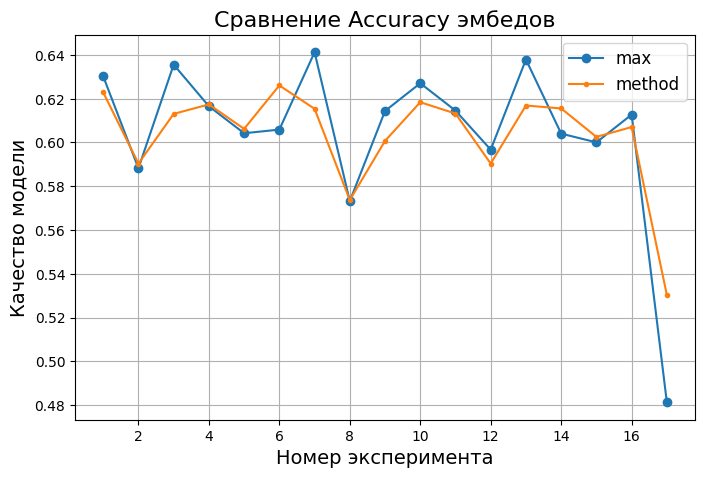

CPU times: user 2h 42min 18s, sys: 13min 9s, total: 2h 55min 28s
Wall time: 55min 55s


In [ ]:
%%time

max_accs = []

for i in range(0, len(embeds), n):

  results[i] = {}


  tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]

  cur_ind_acc = ind_acc[i:i+6]
  max_accs.append(cur_ind_acc.max())

  combination, idx_frst = selection_of_first(tmp_emb)
  # allign(tmp_emb, idx_frst)
  tmp_emb.pop(idx_frst)

  while len(tmp_emb) != 0:

    #выбираем лучшего кандидата
    cur_best, idx_cand, gain = get_best_candidate(combination, tmp_emb)
    tmp_emb.pop(idx_cand)

    #объединяем
    combination = update_combination_components(combination, cur_best, gain)


  metrics = calc_accuracy_of_embeds(combination[0], combination[1])
  results[i] = metrics

  save_res(results, PATH)
  clear_output()


  acc = [i['Accuracy'] for i in results.values()]

  plot_res(max_accs, acc)

In [ ]:
from google.colab import runtime
runtime.unassign()

## Результаты

In [ ]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
metr = 'Accuracy'

In [ ]:
method = load_res('/content/drive/MyDrive/PTLS/data_ensemble_age_group/res_component_method.pkl')
method_acc = [i[metr] for i in method.values()]

In [ ]:
individual_accuracy = load_res('/content/drive/MyDrive/PTLS/data_ensemble_age_group/individual_accuracy.pkl')

ind_acc = np.array([i[metr] for i in individual_accuracy.values()])
ind_max = []
for i in range(0, 102, 6):
  ind_max.append(max(ind_acc[i:i+6]))

mean = load_res('/content/drive/MyDrive/PTLS/data_ensemble_age_group/mean_perfomance.pickle')
mean_acc = np.array([i[metr] for i in mean.values()])


concat = load_res('/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_perfomance.pickle')
concat_acc = np.array([i['uniform_emb_metrs'][metr] for i in concat.values()])


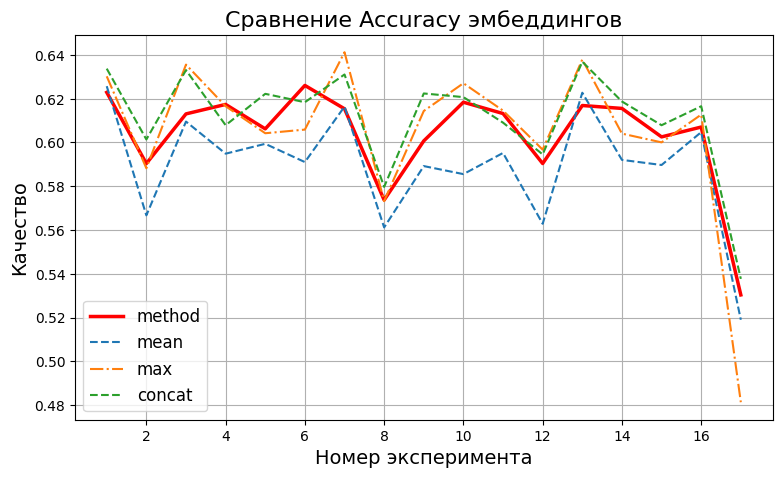

In [ ]:
experiments = np.arange(1, len(method_acc) + 1)

plt.figure(figsize=(9, 5))


plt.plot(experiments, method_acc ,linewidth=2.5, color= 'red',label='method')
plt.plot(experiments, mean_acc, linestyle='--', label='mean')
plt.plot(experiments, ind_max, linestyle='-.', label='max')
plt.plot(experiments, concat_acc, linestyle='--', label='concat')


plt.title(f'Сравнение {metr} эмбеддингов', fontsize=16)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.ylabel('Качество', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)

# Показать график
plt.show()

In [ ]:
base = np.array(method_acc)

metrics = [
    ('Max', ind_max),
    ('Concat', concat_acc),
    ('Mean', mean_acc)
]

results = []
for name, metric in metrics:
    diff = (metric - base) / base
    row = {
        'Metric': name,
        'Mean (%)': diff.mean() * 100,      # Относительное изменение в %
        'Std (%)': diff.std() * 100,         # Стандартное отклонение в %
        'Better (%)': (metric > base).mean() * 100  # Процент случаев
    }
    results.append(row)

# Создание и вывод таблицы
df = pd.DataFrame(results)
df

,Metric,Mean (%),Std (%),Better (%)
0,Max,0.158113,2.995479,52.941176
1,Concat,1.290230,1.481062,82.352941
2,Mean,-2.285110,1.960306,17.647059


## Общая схема

In [ ]:
combination, idx_frst = selection_of_first(embeds)
embeds.pop(idx_frst)

while len(embeds) != 0:

  #выбираем лучшего кандидата, gain - прирост, который он дает
  cur_best, idx_cand, gain = get_best_candidate(combination, embeds)
  embeds.pop(idx_cand)

  #объединяем, учитывая прирост, который дает текущий набор
  combination = update_combination_components(combination, cur_best, gain)

## что поменять

1. при объединении эмбедов кол-во обновлений пропорционально gain и обратно пропорционально качеству добавляемого набора на валидации

# С учетом валидации

## Качество на валидации

In [ ]:
# берем для примера 6 наборов эмбедов
from tqdm import tqdm

embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    val, test = train_test_split(test, test_size = 0.5, random_state=20, stratify = test['target'])
    embeds.append((train, val, test))

100%|██████████| 102/102 [07:09<00:00,  4.21s/it]


In [ ]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 300
TARGET_NAME = 'target'
roles = {
    'target': TARGET_NAME,
    'drop': ['client_id']
}
task = Task('multiclass', metric='crossentropy')


def calc_accuracy_of_embeds(final_embeds_train, final_embeds_val, final_embeds_test):
  # Обучаем и оцениваем на первом наборе эмбеддингов
  automl = TabularAutoML(
      task=task,
      timeout=TIMEOUT,
      cpu_limit=N_THREADS,
      reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
  )

  # Обучаем модель и получаем out-of-fold предсказания
  out_of_fold_predictions = automl.fit_predict(final_embeds_train, roles=roles, verbose=0).data


  # Метрики для многоклассовой классификации
  metrics = {
      "Accuracy": accuracy_score,
      "F1 Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
      "ROC-AUC": lambda y_true, y_proba: roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
  }

  # Предсказания на валидации
  y_proba = automl.predict(final_embeds_val).data
  y_pred = y_proba.argmax(axis=1)  # Выбираем класс с максимальной вероятностью

  y_true = final_embeds_val[TARGET_NAME].values

  all_metrics_val = {
      metric_name: metric_func(y_true, y_pred if metric_name != "ROC-AUC" else y_proba)
      for metric_name, metric_func in metrics.items()
  }


  # Предсказания на тесте
  y_proba = automl.predict(final_embeds_test).data
  y_pred = y_proba.argmax(axis=1)  # Выбираем класс с максимальной вероятностью



  y_true = final_embeds_test[TARGET_NAME].values

  all_metrics_test = {
      metric_name: metric_func(y_true, y_pred if metric_name != "ROC-AUC" else y_proba)
      for metric_name, metric_func in metrics.items()
  }

  return all_metrics_val, all_metrics_test

In [ ]:
def plot_res(a, b):
  experiments = np.arange(1, len(a) + 1)
  plt.figure(figsize=(8, 5))


  plt.plot(experiments, a, marker='o', label='val')
  plt.plot(experiments, b, marker='.', label='test')

  plt.title(f'Сравнение Accuracy эмбедов', fontsize=16)
  plt.xlabel('Номер эксперимента', fontsize=14)
  plt.ylabel('Качество модели', fontsize=14)

  plt.legend(fontsize=12)

  plt.grid(True)

  # Показать график
  plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/individual_accuracy_val_test.pickle'
results = load_res(PATH)

In [ ]:
TIMEOUT = 300

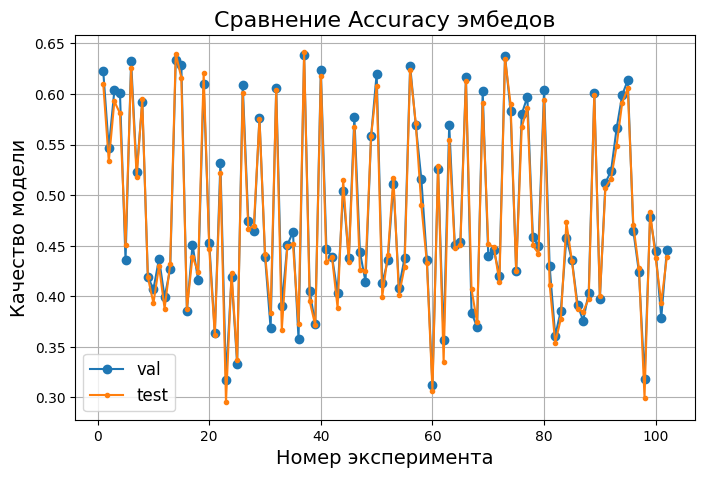

In [ ]:
for i, (train, val, test) in enumerate(embeds):
  if i in results.keys():
    continue
  results[i] = {}
  all_metrics_val, all_metrics_test = calc_accuracy_of_embeds(train, val, test)
  results[i]['val'] = all_metrics_val
  results[i]['test'] = all_metrics_test
  save_res(results, PATH)
  clear_output()

  vl = [i['val']['Accuracy'] for i in results.values()]
  tst = [i['test']['Accuracy'] for i in results.values()]
  plot_res(vl, tst)

## конкат + PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# берем для примера 6 наборов эмбедов
from tqdm import tqdm

embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    val, test = train_test_split(test, test_size = 0.5, random_state=20, stratify = test['target'])
    embeds.append((train, val, test))

100%|██████████| 102/102 [01:39<00:00,  1.02it/s]


In [ ]:
def concat_embeds(embeds):

    # Проверка структуры входных данных
    for e in embeds:
        if len(e) != 3:
            raise ValueError("Каждый элемент embeds должен быть кортежем из 3 датафреймов.")

    # Конкатенация по столбцам для train, val, test
    concat_train = pd.concat([e[0].drop(columns = ['client_id', 'target']) for e in embeds], axis=1)
    concat_test = pd.concat([e[2].drop(columns = ['client_id', 'target']) for e in embeds], axis=1)

    concat_train.columns = [f'emb_{i}' for i in range(concat_train.shape[1])]
    concat_test.columns = [f'emb_{i}' for i in range(concat_test.shape[1])]

    concat_train['target'] = embeds[0][0]['target']
    concat_test['target'] = embeds[0][2]['target']

    return concat_train, concat_test

In [ ]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 300
TARGET_NAME = 'target'
roles = {
    'target': TARGET_NAME,
    'drop': ['client_id']
}
task = Task('multiclass', metric='crossentropy')


def calc_accuracy_of_combination(final_embeds_train, final_embeds_test):
  # Обучаем и оцениваем на первом наборе эмбеддингов
  automl = TabularAutoML(
      task=task,
      timeout=TIMEOUT,
      cpu_limit=N_THREADS,
      reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
  )

  # Обучаем модель и получаем out-of-fold предсказания
  out_of_fold_predictions = automl.fit_predict(final_embeds_train, roles=roles, verbose=0).data

  # Предсказания на тесте
  y_proba = automl.predict(final_embeds_test).data
  y_pred = y_proba.argmax(axis=1)  # Выбираем класс с максимальной вероятностью



  # Метрики для многоклассовой классификации
  metrics = {
      "Accuracy": accuracy_score,
      "F1 Score": lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
      "ROC-AUC": lambda y_true, y_proba: roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
  }

  y_true = final_embeds_test[TARGET_NAME].values

  all_metrics = {
      metric_name: metric_func(y_true, y_pred if metric_name != "ROC-AUC" else y_proba)
      for metric_name, metric_func in metrics.items()
  }

  return all_metrics

In [ ]:
def plot_res(a, b, label1, label2):
  experiments = np.arange(1, len(a) + 1)
  plt.figure(figsize=(8, 5))


  plt.plot(experiments, a, marker='o', label=label1)
  plt.plot(experiments, b, marker='.', label=label2)

  plt.title(f'Сравнение Accuracy эмбедов', fontsize=16)
  plt.xlabel('Номер эксперимента', fontsize=14)
  plt.ylabel('Качество модели', fontsize=14)

  plt.legend(fontsize=12)

  plt.grid(True)

  # Показать график
  plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_perfomance_val_test_PCA.pickle'
results = load_res(PATH)
n = 6

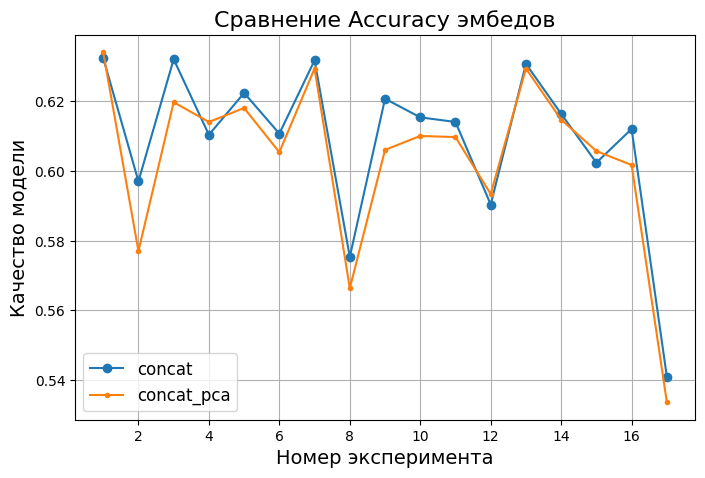

CPU times: user 15h 34min 31s, sys: 4min 28s, total: 15h 39min
Wall time: 4h 18min 56s


In [ ]:
%%time
for i in range(0, len(embeds), n):

  results[i] = {}

  tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]

  concat_train, concat_test = concat_embeds(tmp_emb)

  metrs = calc_accuracy_of_combination(concat_train, concat_test)
  results[i]['concat'] = metrs

  # clear_output()

  pca = PCA(n_components=min(256, concat_train.shape[1]))
  pca_train = pca.fit_transform(concat_train.drop(columns = ['target']))
  pca_test = pca.transform(concat_test.drop(columns = ['target']))
  pca_train, pca_test = pd.DataFrame(pca_train), pd.DataFrame(pca_test)
  pca_train.columns = [f'emb_{i}' for i in range(pca_train.shape[1])]
  pca_test.columns = [f'emb_{i}' for i in range(pca_test.shape[1])]


  pca_train['target'] = concat_train['target'].values
  pca_test['target'] = concat_test['target'].values
  metrs = calc_accuracy_of_combination(pca_train, pca_test)
  results[i]['concat_pca'] = metrs

  clear_output()

  save_res(results, PATH)

  a = [i['concat']['Accuracy'] for i in results.values()]
  b = [i['concat_pca']['Accuracy'] for i in results.values()]
  plot_res(a, b,'concat', 'concat_pca')

In [ ]:
from google.colab import runtime
runtime.unassign()

## Подход с расчетом важностей признаков + комбинированным скором(accuracy+gain)

что делать? \
1) Комбинированный скор, пропорциональный кол-ву координат, которые заменяем alpha * accuracy + (1 - alpha) * gain. Этот же прирост юзаем для отбора след кандидата \
2) первого отбираем по валидации \

Это сравнить с тем что просто берем все конкатим и юзаем PCA + с максимумом, средним и конкатом

In [ ]:
# берем для примера 6 наборов эмбедов
from tqdm import tqdm

embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    val, test = train_test_split(test, test_size = 0.5, random_state=20, stratify = test['target'])
    embeds.append((train, val, test))

100%|██████████| 102/102 [06:05<00:00,  3.59s/it]


In [ ]:
ind_acc = load_res('/content/drive/MyDrive/PTLS/data_ensemble_age_group/individual_accuracy_val_test.pickle')

In [ ]:
val_ind_acc = np.array([i['val']['Accuracy'] for i in ind_acc.values()])

In [ ]:
def selection_of_first(embeddings, cur_ind_acc):
  """
  Выбирает первого кандидата в комбинацию по качеству на валидации
  """

  idx_frst = np.argmax(cur_ind_acc)
  first_emb = embeddings[idx_frst]

  return first_emb, idx_frst

In [ ]:
def information_gain_CKA(emb_a, emb_b):
  cls = ALL_MEASURES["CKA"]
  current_corr = cls(emb_a, emb_b, shape = 'nd')
  # print(current_corr)
  return 1 - current_corr

In [ ]:
def get_best_candidate(combination, candidates, val_accuracies, alpha=0.5):

    """
    return candidate, idx, gain, cal_acc, score
    """
    base = combination[0].iloc[:, :256].values


    gains = np.array([information_gain_CKA(base, train.iloc[:, :256].values) for (train, _, _) in candidates])
    # print('gains', gains, 'val_accuracies', val_accuracies)
    # normalized_gains = gains / max(gains)
    # normalized_acc = val_accuracies / max(val_accuracies)

    best_idx = 0
    max_score = -np.inf

    for i in range(len(candidates)):
      # score = alpha*normalized_gains[i] + (1-alpha)*normalized_acc[i]
      score = alpha*gains[i] + (1-alpha)*val_accuracies[i]
      if score > max_score:
            max_score = score
            best_idx = i

    return candidates[best_idx], best_idx, max_score

In [ ]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier


def calculate_l1_importance(X, y, C=0.1):
    model = LogisticRegression(penalty='l1', solver='saga', C=C, max_iter=100)
    model.fit(X, y)
    return np.abs(model.coef_[0])

def calculate_lgbm_importance(X, y):
    model = LGBMClassifier(n_estimators=50, verbosity=-1)
    model.fit(X, y)
    return model.feature_importances_

def var_importance(X):
    return np.var(X)

In [ ]:
def update_combination_coordinates(combination, new_candidate, score, step, max_percent = 0.2, decay_rate = 0.85):

    comb_train = combination[0].iloc[:, :256].values
    comb_test = combination[2].iloc[:, :256].values
    new_train = new_candidate[0].iloc[:, :256].values
    new_test = new_candidate[2].iloc[:, :256].values


    # расчет важностей
    comb_imp = calculate_lgbm_importance(comb_train, combination[0].target)
    new_imp = calculate_lgbm_importance(new_train, new_candidate[0].target)
    # comb_imp = var_importance(comb_train)
    # new_imp = var_importance(new_train)

    # Динамическое количество замен
    # n_replace = int(comb_train.shape[1] * (0.05 + 0.15 * gain * val_acc))
    max_replace = int(comb_train.shape[1] * max_percent * (decay_rate**(step)))  # Макс 20%
    n_replace = int(max_replace * score)      # Линейная растет от score

    # Выбор заменяемых индексов
    replace_indices = np.argsort(comb_imp)[:n_replace]
    top_new_indices = np.argsort(new_imp)[-n_replace:]


    # Обновление данных
    comb_train[:, replace_indices] = new_train[:, top_new_indices]
    comb_test[:, replace_indices] = new_test[:, top_new_indices]

    # Возвращаем обновленные данные
    combination[0].iloc[:, :256] = comb_train
    combination[2].iloc[:, :256] = comb_test


    print(f"Score {score} -> Заменено {n_replace} компонент")

    return combination

In [ ]:
def plot_res(a, b, label1, label2):
  experiments = np.arange(1, len(a) + 1)
  plt.figure(figsize=(8, 5))


  plt.plot(experiments, a, marker='o', label=label1)
  plt.plot(experiments, b, marker='.', label=label2)

  plt.title(f'Сравнение Accuracy эмбедов', fontsize=16)
  plt.xlabel('Номер эксперимента', fontsize=14)
  plt.ylabel('Качество модели', fontsize=14)

  plt.legend(fontsize=12)

  plt.grid(True)

  # Показать график
  plt.show()

In [ ]:
TIMEOUT = 300
n = 6

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/res_coordinate_method_acc_val.pkl'
results = load_res(PATH)

In [ ]:
# results = {}

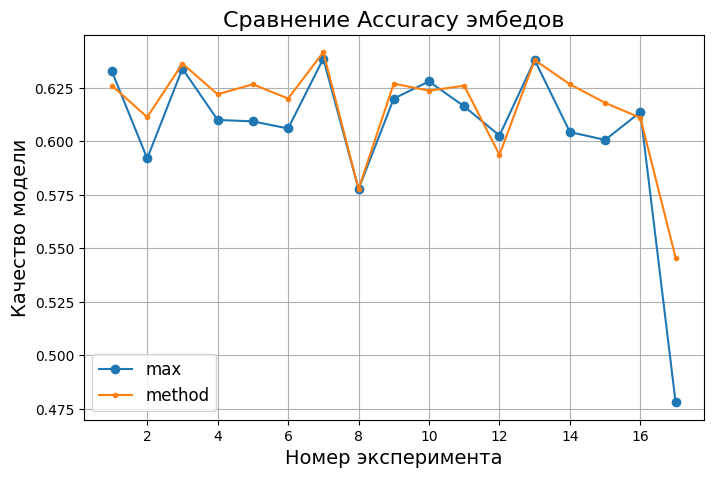

CPU times: user 3h 43min 36s, sys: 1min 26s, total: 3h 45min 3s
Wall time: 1h


In [ ]:
%%time

# max_accs = []

for i in range(18, len(embeds), n):

  results[i] = {}

  tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]
  cur_ind_acc = val_ind_acc[i:i+6]
  max_accs.append(cur_ind_acc.max())

  combination, idx_frst = selection_of_first(tmp_emb, cur_ind_acc)
  tmp_emb.pop(idx_frst)
  cur_ind_acc = np.delete(cur_ind_acc, idx_frst)

  step_counter = 0
  while len(tmp_emb) != 0:

    #выбираем лучшего кандидата
    candidate, idx_cand, score_cand = get_best_candidate(combination, tmp_emb, cur_ind_acc)
    tmp_emb.pop(idx_cand)
    cur_ind_acc = np.delete(cur_ind_acc, idx_cand)

    #объединяем
    combination = update_combination_coordinates(combination, candidate, score_cand, step_counter)
    step_counter +=1

  metrics = calc_accuracy_of_embeds(combination[0], combination[2])
  results[i] = metrics

  save_res(results, PATH)
  clear_output()


  acc = [i['Accuracy'] for i in results.values()]

  plot_res(max_accs, acc, 'max', 'method')

### Сравнение с конкатом PCA

In [ ]:
method = [i['Accuracy'] for i in results.values()]

In [ ]:
print(max_accs)

[0.6326666666666667, 0.592, 0.634, 0.61, 0.6093333333333333, 0.606, 0.6386666666666667, 0.5776666666666667, 0.62, 0.628, 0.6163333333333333, 0.6026666666666667, 0.638, 0.6043333333333333, 0.6006666666666667, 0.6136666666666667, 0.478]


In [ ]:
concat = load_res('/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_perfomance_val_test_PCA.pickle')

In [ ]:
metr = 'Accuracy'

In [ ]:
concat_base = [i['concat']['Accuracy'] for i in concat.values()]
concat_pca = [i['concat_pca']['Accuracy'] for i in concat.values()]

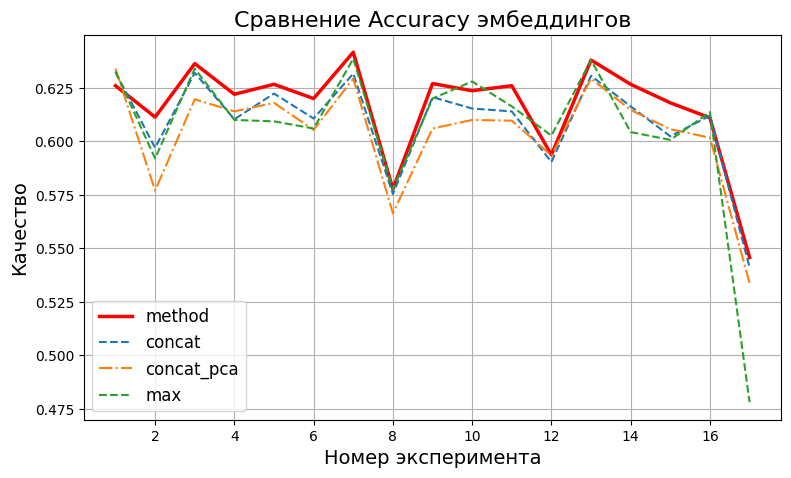

In [ ]:
experiments = np.arange(1, len(method) + 1)

plt.figure(figsize=(9, 5))


plt.plot(experiments, method, linewidth=2.5, color= 'red', label='method')
plt.plot(experiments, concat_base, linestyle='--', label='concat')
plt.plot(experiments, concat_pca, linestyle='-.', label='concat_pca')
plt.plot(experiments, max_accs, linestyle='--', label='max')


plt.title(f'Сравнение {metr} эмбеддингов', fontsize=16)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.ylabel('Качество', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)

# Показать график
plt.show()

In [ ]:
base = np.array(method)

metrics = [
    ('concat', concat_base),
    ('concat_pca', concat_pca),
    ('max', max_accs)
]

results = []
for name, metric in metrics:
    diff = (base - metric) / metric
    row = {
        'Metric': name,
        'Mean (%)': diff.mean() * 100,      # Относительное изменение в %
        'Std (%)': diff.std() * 100,         # Стандартное отклонение в %
        'Better (%)': (metric < base).mean() * 100  # Процент случаев
    }
    results.append(row)

# Создание и вывод таблицы
df = pd.DataFrame(results)
df

,Metric,Mean (%),Std (%),Better (%)
0,concat,1.131951,0.884956,88.235294
1,concat_pca,2.004343,1.431632,94.117647
2,max,1.822871,3.446688,64.705882


Почему конкат такой слабый? сравним с конкатом на всех данных

In [ ]:
concat_val = load_res('/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_perfomance_val_test_PCA.pickle')
concat_base_val = [i['concat']['Accuracy'] for i in concat_val.values()]
concat_pca_val = [i['concat_pca']['Accuracy'] for i in concat_val.values()]

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_perfomance.pickle'
concat = load_res(PATH)
concat = np.array([i['uniform_emb_metrs']['Accuracy'] for i in concat.values()])

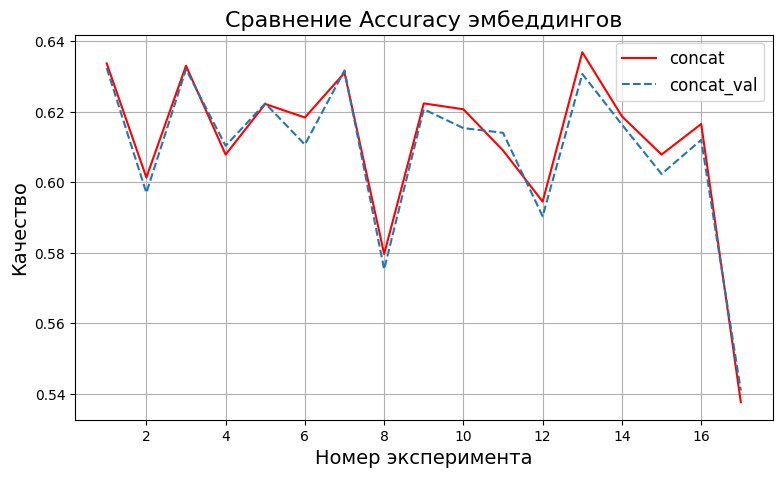

In [ ]:
experiments = np.arange(1, len(concat) + 1)

plt.figure(figsize=(9, 5))


plt.plot(experiments, concat, color= 'red',label='concat')
plt.plot(experiments, concat_base_val, linestyle='--', label='concat_val')
# plt.plot(experiments, concat_pca_val, linestyle='-.', label='concat_pca_val')


plt.title(f'Сравнение Accuracy эмбеддингов', fontsize=16)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.ylabel('Качество', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)

# Показать график
plt.show()

In [ ]:
diff = (concat - concat_base_val) / concat_base_val
round(diff.mean() * 100, 2), round(diff.std() * 100, 2), round((concat_base_val < concat).mean() * 100, 2)

(np.float64(0.35), np.float64(0.58), np.float64(70.59))

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/res_coordinate_method_acc_val.pkl'
method = load_res(PATH)
method = [i['Accuracy'] for i in method.values()]

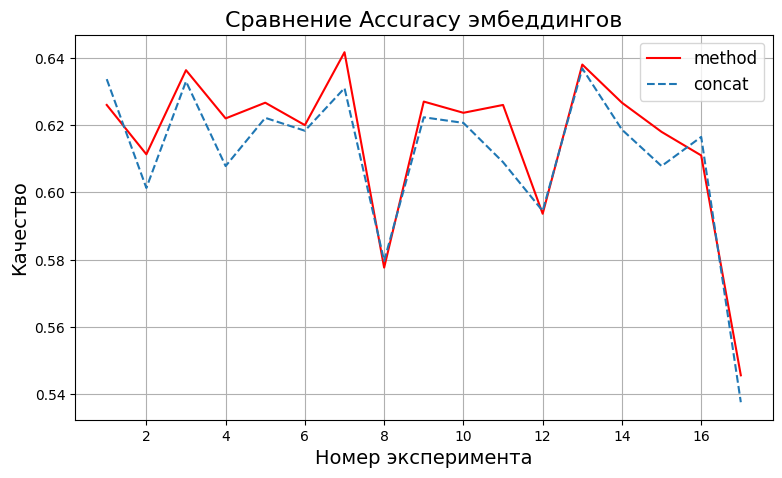

In [ ]:
experiments = np.arange(1, len(concat) + 1)

plt.figure(figsize=(9, 5))


plt.plot(experiments, method, color= 'red',label='method')
plt.plot(experiments, concat, linestyle='--', label='concat')
# plt.plot(experiments, concat_pca_val, linestyle='-.', label='concat_pca_val')


plt.title(f'Сравнение Accuracy эмбеддингов', fontsize=16)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.ylabel('Качество', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)

# Показать график
plt.show()

In [ ]:
diff = (method - concat) / concat
round(diff.mean() * 100, 2), round(diff.std() * 100, 2), round((concat < method).mean() * 100, 2)

(np.float64(0.78), np.float64(1.06), np.float64(76.47))

## concat + MLP

In [ ]:
# берем для примера 6 наборов эмбедов
from tqdm import tqdm

embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    val, test = train_test_split(test, test_size = 0.5, random_state=20, stratify = test['target'])
    embeds.append((train, val, test))

100%|██████████| 102/102 [06:26<00:00,  3.79s/it]


In [ ]:
def concat_embeds(embeds):

    # Проверка структуры входных данных
    for e in embeds:
        if len(e) != 3:
            raise ValueError("Каждый элемент embeds должен быть кортежем из 3 датафреймов.")

    # Конкатенация по столбцам для train, val, test
    concat_train = pd.concat([e[0].drop(columns = ['client_id', 'target']) for e in embeds], axis=1)
    concat_val = pd.concat([e[1].drop(columns = ['client_id', 'target']) for e in embeds], axis=1)
    concat_test = pd.concat([e[2].drop(columns = ['client_id', 'target']) for e in embeds], axis=1)

    concat_train.columns = [f'emb_{i}' for i in range(concat_train.shape[1])]
    concat_val.columns = [f'emb_{i}' for i in range(concat_val.shape[1])]
    concat_test.columns = [f'emb_{i}' for i in range(concat_test.shape[1])]

    concat_train['target'] = embeds[0][0]['target']
    concat_val['target'] = embeds[0][1]['target']
    concat_test['target'] = embeds[0][2]['target']

    return concat_train, concat_val, concat_test

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Определение архитектуры MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        prev_size = input_size
        for size in hidden_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            prev_size = size
        layers.append(nn.Linear(prev_size, output_size))
        self.net = nn.Sequential(*layers)
        self.double()

    def forward(self, x):
        return self.net(x)

In [ ]:
# device

In [ ]:
def calc_accuracy_of_mlp(final_embeds_train, final_embeds_val, final_embeds_test, max_epochs = 2000):

    model = MLP(256*6, [256, 128, 64, 32], 4).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    X_train, y_train = torch.tensor(final_embeds_train.iloc[:, :-1].values, device = device), torch.tensor(final_embeds_train.iloc[:,-1].values, device = device)
    X_val, y_val = torch.tensor(final_embeds_val.iloc[:, :-1].values, device = device), torch.tensor(final_embeds_val.iloc[:,-1].values, device = device)
    X_test, y_test = torch.tensor(final_embeds_test.iloc[:, :-1].values, device = device), torch.tensor(final_embeds_test.iloc[:,-1].values, device = device)

    # Обучение с ранней остановкой
    best_val_loss = float('inf')
    patience = 10
    counter = 0
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0.0
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

         # Validation
        model.eval()
        with torch.no_grad():
          outputs = model(X_val)
          loss = criterion(outputs, y_val)
          val_loss = loss.item()


        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # print(epoch, best_val_loss)
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    # предсказания
    outputs = model(X_train)
    train_probs = torch.softmax(outputs, dim=1)
    _, train_preds = torch.max(outputs, 1)

    outputs = model(X_test)
    test_probs = torch.softmax(outputs, dim=1)
    _, test_preds = torch.max(outputs, 1)

    return {
        "Accuracy": accuracy_score(y_test.detach().cpu().numpy(), test_preds.detach().cpu().numpy()),
        "F1 Score": f1_score(y_test.detach().cpu().numpy(), test_preds.detach().cpu().numpy(), average='weighted'),
        "ROC-AUC": roc_auc_score(y_test.detach().cpu().numpy(), test_probs.detach().cpu().numpy(), multi_class='ovr', average='weighted')
    }

In [ ]:
# calc_accuracy_of_mlp(concat_train, concat_val, concat_test)

In [ ]:
def plot_res(a):
  experiments = np.arange(1, len(a) + 1)
  plt.figure(figsize=(8, 5))


  plt.plot(experiments, a, marker='o', label='MLP')

  plt.title(f'Accuracy эмбедов', fontsize=16)
  plt.xlabel('Номер эксперимента', fontsize=14)
  plt.ylabel('Качество модели', fontsize=14)

  plt.legend(fontsize=12)

  plt.grid(True)

  # Показать график
  plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_MLP_2_perfomance_val_test.pickle'
results = load_res(PATH)
n = 6

In [ ]:
results = {}

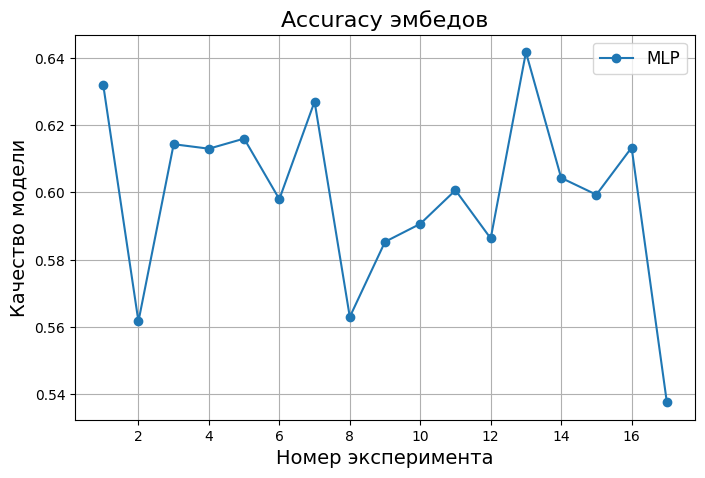

CPU times: user 9min 31s, sys: 9.78 s, total: 9min 41s
Wall time: 9min 34s


In [ ]:
%%time
for i in range(0, len(embeds), n):

  results[i] = {}

  tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]

  concat_train, concat_val, concat_test = concat_embeds(tmp_emb)

  metrs = calc_accuracy_of_mlp(concat_train, concat_val, concat_test)
  results[i] = metrs
  save_res(results, PATH)
  clear_output()

  a = [i['Accuracy'] for i in results.values()]
  plot_res(a)

In [ ]:
# from google.colab import runtime
# runtime.unassign()

# Конкат + отбор фичей по бустингу

In [ ]:
def calculate_lgbm_importance(X, y):
    model = LGBMClassifier(n_estimators=200, verbosity=-1)
    model.fit(X, y)
    return model.feature_importances_

In [ ]:
def plot_res(a):
  experiments = np.arange(1, len(a) + 1)
  plt.figure(figsize=(8, 5))


  plt.plot(experiments, a, marker='o', label='concat_lgbm')

  plt.title(f'Accuracy эмбедов', fontsize=16)
  plt.xlabel('Номер эксперимента', fontsize=14)
  plt.ylabel('Качество модели', fontsize=14)

  plt.legend(fontsize=12)

  plt.grid(True)

  # Показать график
  plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_lgbm_perfomance_val_test.pickle'
results = load_res(PATH)
n = 6

In [ ]:
results.keys()

dict_keys([0, 6, 12])

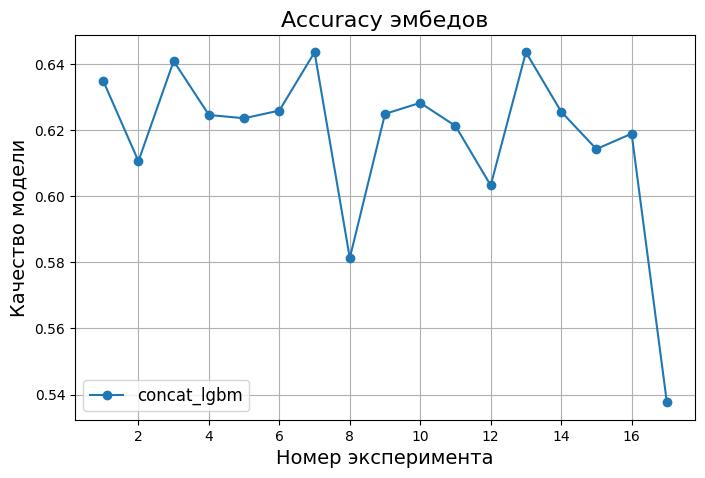

CPU times: user 3h 37min 26s, sys: 10min 52s, total: 3h 48min 18s
Wall time: 1h 8min 47s


In [ ]:
%%time
for i in range(18, len(embeds), n):

  results[i] = {}

  tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]

  concat_train, concat_val, concat_test = concat_embeds(tmp_emb)

  importances = calculate_lgbm_importance(concat_train.iloc[:, :-1].values, concat_train.iloc[:, -1].values)
  top_indices = np.argsort(importances)[-256:]
  new_cols = ['emb_'+str(idx) for idx in top_indices] + ['target']

  metrs = calc_accuracy_of_embeds(concat_train[new_cols], concat_test[new_cols])
  results[i] = metrs
  save_res(results, PATH)
  clear_output()

  a = [i['Accuracy'] for i in results.values()]
  plot_res(a)

In [ ]:
from google.colab import runtime
runtime.unassign()

# Сравнение supervised ConcatMLP, ConcatLightGBM, method

In [ ]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
metr = 'Accuracy'

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_lgbm_perfomance_val_test.pickle'
results = load_res(PATH)
lightgbm = [i['Accuracy'] for i in results.values()]

PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_MLP_perfomance_val_test.pickle'
results = load_res(PATH)
mlp = [i['Accuracy'] for i in results.values()]

PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/res_coordinate_method_acc_val.pkl'
results = load_res(PATH)
mathod = [i['Accuracy'] for i in results.values()]

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/concat_MLP_2_perfomance_val_test.pickle'
results = load_res(PATH)
mlp2 = [i['Accuracy'] for i in results.values()]

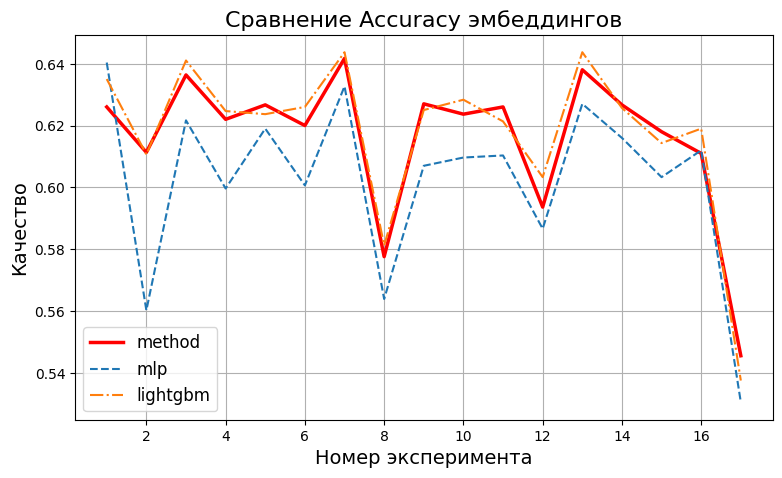

In [ ]:
experiments = np.arange(1, len(mathod) + 1)

plt.figure(figsize=(9, 5))


plt.plot(experiments, mathod, linewidth=2.5, color= 'red', label='method')
# plt.plot(experiments, mlp2, linestyle='--', label='mlp2')
plt.plot(experiments, mlp, linestyle='--', label='mlp')
plt.plot(experiments, lightgbm, linestyle='-.', label='lightgbm')

plt.title(f'Сравнение {metr} эмбеддингов', fontsize=16)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.ylabel('Качество', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)

# Показать график
plt.show()

In [ ]:
base = np.array(mathod)

metrics = [
    ('lightgbm', lightgbm),
    ('mlp', mlp),
    # ('max', max_accs)
]

results = []
for name, metric in metrics:
    diff = (base - metric) / metric
    row = {
        'Metric': name,
        'Mean (%)': diff.mean() * 100,      # Относительное изменение в %
        'Std (%)': diff.std() * 100,         # Стандартное отклонение в %
        'Better (%)': (metric < base).mean() * 100  # Процент случаев
    }
    results.append(row)

# Создание и вывод таблицы
df = pd.DataFrame(results)
df

,Metric,Mean (%),Std (%),Better (%)
0,lightgbm,-0.299059,0.829004,41.176471
1,mlp,2.304779,2.181713,88.235294


# Влияет ли выравнивание на метрики

In [ ]:
embeds = []

for i in tqdm(range(6)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    embeds.append((train, test))

100%|██████████| 6/6 [00:29<00:00,  4.84s/it]


посчитаем корреляционную матрицу до и после выравнивания

In [ ]:
def extract_upper_triangle(matrix):
    """
    Извлекает верхний треугольник матрицы (без диагонали).
    """
    n = matrix.shape[0]
    indices = torch.triu_indices(n, n, offset=1)
    return matrix[indices[0], indices[1]]

def compute_correlation(distances1, distances2):
    """
    Вычисляет корреляцию между двумя векторами расстояний.
    """
    mean1, mean2 = distances1.mean(), distances2.mean()
    centered1, centered2 = distances1 - mean1, distances2 - mean2
    covariance = (centered1 * centered2).sum() / len(distances1)
    std1, std2 = distances1.std(), distances2.std()
    return covariance / (std1 * std2)

def my_correlation_metric(X, Y):
    distance_1 = extract_upper_triangle(torch.cdist(X, X))
    distance_2 = extract_upper_triangle(torch.cdist(Y, Y))
    metric = compute_correlation(distance_1, distance_2)
    return metric.item()

In [ ]:
def calc_corr_matrix(embeds, metric, n = 6):
  if metric in ['RankSimilarity', 'CKA', 'RSA', 'OrthogonalAngularShapeMetricCentered', 'PermutationProcrustes']:
    cls = ALL_MEASURES[metric]
    corr_matrix = np.zeros((n, n))
    for i in range(n):
        emb_i = embeds[i][0].iloc[:, :256].values

        for j in range(i, n):
            emb_j = embeds[j][0].iloc[:, :256].values

            current_corr = cls(emb_i, emb_j, shape = 'nd')

            corr_matrix[i, j] = current_corr
            corr_matrix[j, i] = current_corr

    return corr_matrix

  elif metric == 'rtd':
    # тут будет несколько

    corr_matrix_rtd = np.zeros((n, n))

    for i in range(n):
        emb_i = torch.tensor(embeds[i][0].iloc[:, :256].values, device = device)

        for j in range(1, n):
            if i == j:
              corr_matrix_rtd[i, j] = 0
              continue


            emb_j = torch.tensor(embeds[j][0].iloc[:, :256].values, device = device)

            corr_matrix_rtd[i, j] = rtd.rtd(emb_i, emb_j, pdist_device = device)

    return corr_matrix_rtd

  elif metric == 'my_correlation_metric':
    corr_matrix = np.zeros((n, n))
    for i in range(n):
        emb_i = torch.tensor(embeds[i][0].iloc[:, :256].values, device = device)

        for j in range(i, n):

            emb_j = torch.tensor(embeds[j][0].iloc[:, :256].values, device = device)

            current_corr = my_correlation_metric(emb_i, emb_j)

            corr_matrix[i, j] = current_corr
            corr_matrix[j, i] = current_corr

    return corr_matrix

In [ ]:
def allign(tmp_emb, idx_base):
  #приводим все в пространство idx_base набора
  base_space = torch.tensor(tmp_emb[idx_base][0].iloc[:,:256].values, device = device)

  for j, (cur_train, cur_test) in enumerate(tmp_emb):
    translator_proc = Procrustes()
    cur_tr = torch.tensor(cur_train.iloc[:,:256].values, device = device)
    cur_ts = torch.tensor(cur_test.iloc[:,:256].values, device = device)

    translator_proc.fit(x=cur_tr, y=base_space)
    transformed_train = translator_proc(cur_tr)['x']
    transformed_test = translator_proc(cur_ts)['x']

    cur_train.iloc[:,:256] = transformed_train.cpu().numpy()
    cur_test.iloc[:,:256] = transformed_test.cpu().numpy()

In [ ]:
i = 0
tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]

CKA

In [ ]:
print(calc_corr_matrix(tmp_emb, metric = 'CKA', n = 6))

[[1.         0.70829494 0.65545425 0.80038335 0.3218723  0.82913622]
 [0.70829494 1.         0.5954186  0.77938402 0.11675919 0.61072143]
 [0.65545425 0.5954186  1.         0.70229122 0.13440005 0.63216482]
 [0.80038335 0.77938402 0.70229122 1.         0.15284554 0.76875327]
 [0.3218723  0.11675919 0.13440005 0.15284554 1.         0.3820449 ]
 [0.82913622 0.61072143 0.63216482 0.76875327 0.3820449  1.        ]]


In [ ]:
allign(tmp_emb, 0)

In [ ]:
print(calc_corr_matrix(tmp_emb, metric = 'CKA', n = 6))

[[1.         0.64213791 0.57847642 0.7638471  0.22385476 0.79176918]
 [0.64213791 1.         0.48932497 0.72594117 0.05720249 0.55883158]
 [0.57847642 0.48932497 1.         0.59059459 0.11825261 0.58683932]
 [0.7638471  0.72594117 0.59059459 1.         0.08187705 0.74067676]
 [0.22385476 0.05720249 0.11825261 0.08187705 1.         0.21552556]
 [0.79176918 0.55883158 0.58683932 0.74067676 0.21552556 1.        ]]


RTD

In [ ]:
i = 0
tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]

In [ ]:
print(calc_corr_matrix(tmp_emb, metric = 'rtd', n = 6))

[[ 0.         38.71232982 32.87866876 22.57968509 40.12290141 19.09656782]
 [ 0.          0.         34.24552813 30.2356718  47.83180841 41.01108448]
 [ 0.         34.26547986  0.         27.98366474 48.76902391 33.75037634]
 [ 0.         29.96770327 27.83796182  0.         42.8585887  23.80255109]
 [ 0.         48.07743537 49.05879107 42.4837392   0.         40.78593268]
 [ 0.         41.19886161 34.35488626 23.63312439 40.66728444  0.        ]]


In [ ]:
tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]
allign(tmp_emb, 0)

In [ ]:
print(calc_corr_matrix(tmp_emb, metric = 'rtd', n = 6))

[[ 0.         42.9496298  50.68961563 29.84562314 50.1902427  24.58064283]
 [ 0.          0.         35.48095267 28.52349176 40.58655273 36.99506663]
 [ 0.         35.74106133  0.         36.0801547  41.28488242 38.93459015]
 [ 0.         28.38348634 35.15393013  0.         41.96624163 24.79699966]
 [ 0.         40.14542677 40.49862158 40.95510421  0.         45.58570854]
 [ 0.         36.30840752 37.84135123 24.19070741 45.01233982  0.        ]]


my_correlation_metric

In [ ]:
i = 0
tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]
print(calc_corr_matrix(tmp_emb, metric = 'my_correlation_metric', n = 6))

[[1.         0.69713987 0.62204907 0.79716125 0.36393519 0.83153348]
 [0.69713987 1.         0.57351173 0.79284724 0.11425482 0.63364187]
 [0.62204907 0.57351173 1.         0.66895885 0.15243272 0.60764999]
 [0.79716125 0.79284724 0.66895885 1.         0.15853436 0.78252908]
 [0.36393519 0.11425482 0.15243272 0.15853436 1.         0.36819313]
 [0.83153348 0.63364187 0.60764999 0.78252908 0.36819313 1.        ]]


In [ ]:
tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]
allign(tmp_emb, 0)

In [ ]:
print(calc_corr_matrix(tmp_emb, metric = 'my_correlation_metric', n = 6))

[[1.         0.6135055  0.30998469 0.73635411 0.21171069 0.63232627]
 [0.6135055  1.         0.24470202 0.70077052 0.0633049  0.4446079 ]
 [0.30998469 0.24470202 1.         0.35348979 0.19361169 0.37170771]
 [0.73635411 0.70077052 0.35348979 1.         0.10922581 0.64728933]
 [0.21171069 0.0633049  0.19361169 0.10922581 1.         0.22834629]
 [0.63232627 0.4446079  0.37170771 0.64728933 0.22834629 1.        ]]


# Unsupervised с отбором по нескольким метрикам + выравнивание

In [ ]:
embeds = []

for i in tqdm(range(102)):

    train = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/train_df{i}.csv').iloc[:,1:]
    test = pd.read_csv(f'/content/drive/MyDrive/PTLS/data_ensemble_age_group/test_df{i}.csv').iloc[:,1:]

    embeds.append((train, test))

100%|██████████| 102/102 [07:22<00:00,  4.34s/it]


In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/individual_accuracy.pkl'
ind_acc = load_res(PATH)
ind_acc = np.array([value['Accuracy'] for value in ind_acc.values()])

In [ ]:
def allign(tmp_emb, idx_base):
  #приводим все в пространство idx_base набора
  base_space = torch.tensor(tmp_emb[idx_base][0].iloc[:,:256].values, device = device)

  for j, (cur_train, cur_test) in enumerate(tmp_emb):
    translator_proc = Procrustes()
    cur_tr = torch.tensor(cur_train.iloc[:,:256].values, device = device)
    cur_ts = torch.tensor(cur_test.iloc[:,:256].values, device = device)

    translator_proc.fit(x=cur_tr, y=base_space)
    transformed_train = translator_proc(cur_tr)['x']
    transformed_test = translator_proc(cur_ts)['x']

    cur_train.iloc[:,:256] = transformed_train.cpu().numpy()
    cur_test.iloc[:,:256] = transformed_test.cpu().numpy()

In [ ]:
def rankme(
    tensor,
    epsilon = 1e-12,
):

  s = np.linalg.svd(tensor, compute_uv=False)
  p_ks = s / np.sum(s + epsilon) + epsilon
  return np.exp(-np.sum(p_ks * np.log(p_ks)))

def selection_of_first(embeddings):
  """
  Выбирает первого кандидата в комбинацию
  """

  max_rankme = 0
  for i in range(len(embeddings)):
    cur_rankme = rankme(embeddings[i][0].iloc[:,:256].values)
    if cur_rankme > max_rankme:
      max_rankme = cur_rankme
      idx_frst = i

  return embeddings[idx_frst], idx_frst

In [ ]:
def information_gain_CKA(emb_a, emb_b):
  cls = ALL_MEASURES["CKA"]
  current_corr = cls(emb_a, emb_b, shape = 'nd')
  # print(current_corr)
  return 1 - current_corr

In [ ]:
def get_best_candidate(combination, candidates):
  """
  Выбирает из candidates того, кто дает наибольший прирост информации
  """
  base = combination[0].iloc[:, :256].values

  best_idx = 0
  max_gain = 0

  for i, (train, test) in enumerate(candidates):
    cur_train = train.iloc[:, :256].values
    cur_gain = information_gain_CKA(base, cur_train)
    if cur_gain > max_gain:
      max_gain = cur_gain
      best_idx = i

  return candidates[best_idx], best_idx, max_gain

In [ ]:
def update_combination_components(combination, new_candidate, gain, max_percent = 0.2):
    """
    Обновляет комбинацию эмбеддингов с корректной обработкой тестовых данных
    """
    # Извлечение данных
    comb_train = combination[0].iloc[:, :256].values
    comb_test = combination[1].iloc[:, :256].values
    new_train = new_candidate[0].iloc[:, :256].values
    new_test = new_candidate[1].iloc[:, :256].values

    current_var = np.var(comb_train, axis=0)
    new_var = np.var(new_train, axis=0)

    # Автоматический расчет числа заменяемых признаков
    n_total = comb_train.shape[1]
    max_replace = int(np.ceil(n_total * max_percent))  # Макс 20%
    n_replace = int(max_replace * gain)      # Линейная убывает если большой CKA

    # Выбор индексов для замены
    replace_indices = np.argsort(current_var)[:n_replace]
    top_new_indices = np.argsort(new_var)[-n_replace:]

    # Обновление данных
    comb_train[:, replace_indices] = new_train[:, top_new_indices]
    comb_test[:, replace_indices] = new_test[:, top_new_indices]

    # Возвращаем обновленные данные
    combination[0].iloc[:, :256] = comb_train
    combination[1].iloc[:, :256] = comb_test


    print(f"Gain: {gain:.2f} → Заменено {n_replace} компонент")

    return combination

In [ ]:
def plot_res(a, b, label1, label2):
  experiments = np.arange(1, len(a) + 1)
  plt.figure(figsize=(8, 5))


  plt.plot(experiments, a, marker='o', label=label1)
  plt.plot(experiments, b, marker='.', label=label2)

  plt.title(f'Сравнение Accuracy эмбедов', fontsize=16)
  plt.xlabel('Номер эксперимента', fontsize=14)
  plt.ylabel('Качество модели', fontsize=14)

  plt.legend(fontsize=12)

  plt.grid(True)

  # Показать график
  plt.show()

In [ ]:
def allign_scnd_to_frst(frst, scnd):

  base_space = torch.tensor(frst[0].iloc[:,:256].values, device = device)

  translator_proc = Procrustes()
  scnd_tr = torch.tensor(scnd[0].iloc[:,:256].values, device = device)
  scnd_ts = torch.tensor(scnd[1].iloc[:,:256].values, device = device)

  translator_proc.fit(x=scnd_tr, y=base_space)
  transformed_train = translator_proc(scnd_tr)['x']
  transformed_test = translator_proc(scnd_ts)['x']

  scnd[0].iloc[:,:256] = transformed_train.cpu().numpy()
  scnd[1].iloc[:,:256] = transformed_test.cpu().numpy()

  # return scnd

In [ ]:
def allign_tmp_to_combination(combination, tmp_emb):
  for emb in tmp_emb:
    allign_scnd_to_frst(combination, emb)

In [ ]:
def update_combination_base(combination, new_candidate, alpha = 0.8):
  """
  Добавляет нового кандидата в комбинацию
  """
  #train
  combination[0].iloc[:, :256] = alpha * combination[0].iloc[:, :256] + (1 - alpha) * new_candidate[0].iloc[:, :256]
  #test
  combination[1].iloc[:, :256] = alpha * combination[1].iloc[:, :256] + (1 - alpha) * new_candidate[1].iloc[:, :256]
  # return combination

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/res_coordinate_2_base_method.pkl'
results = load_res(PATH)

In [ ]:
TIMEOUT = 300
n = 6

In [ ]:
results = {}

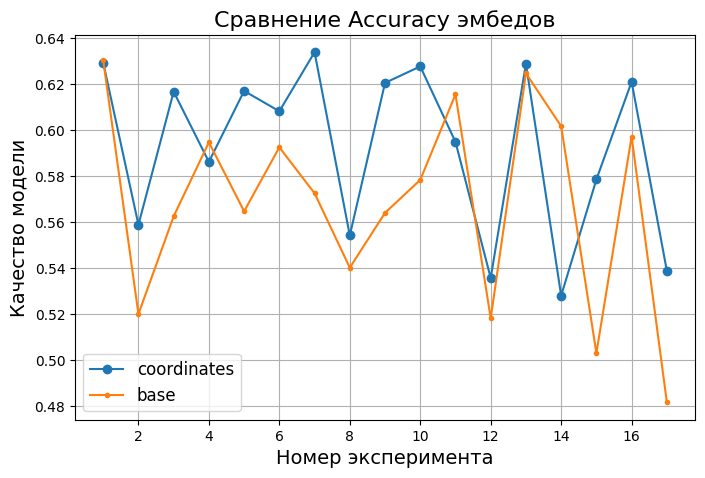

CPU times: user 6h 2min 32s, sys: 28min 59s, total: 6h 31min 31s
Wall time: 2h 5min 2s


In [ ]:
%%time

for i in range(0, len(embeds), n):

  results[i] = {}

  tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]
  cur_ind_acc = ind_acc[i:i+6]
  combination, idx_frst = selection_of_first(tmp_emb)
  # allign(tmp_emb, idx_frst)
  tmp_emb.pop(idx_frst)
  while len(tmp_emb) != 0:

    #выбираем лучшего кандидата
    cur_best, idx_cand, gain = get_best_candidate(combination, tmp_emb)
    tmp_emb.pop(idx_cand)

    #объединяем
    combination = update_combination_components(combination, cur_best, gain, max_percent = 0.8)

  metrics = calc_accuracy_of_embeds(combination[0], combination[1])
  results[i]['coordinates'] = metrics


  #базовый вариант
  tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]

  combination, idx_frst = selection_of_first(tmp_emb)

  tmp_emb.pop(idx_frst)

  while len(tmp_emb) != 0:
    #выбираем лучшего кандидата
    allign_tmp_to_combination(combination, tmp_emb)
    cur_best, idx_cand, gain = get_best_candidate(combination, tmp_emb)
    tmp_emb.pop(idx_cand)
    #объединяем
    update_combination_base(combination, cur_best, 0.8),# gain)


  metrics = calc_accuracy_of_embeds(combination[0], combination[1])
  results[i]['base'] = metrics

  save_res(results, PATH)
  clear_output()


  coord = [i['coordinates']['Accuracy'] for i in results.values()]
  base = [i['base']['Accuracy'] for i in results.values()]

  plot_res(coord, base, 'coordinates', 'base')

## Сравнение

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/individual_accuracy.pkl'
ind_acc = load_res(PATH)
ind_acc = np.array([value['Accuracy'] for value in ind_acc.values()])

In [ ]:
def rankme(
    tensor,
    epsilon = 1e-12,
):

  s = np.linalg.svd(tensor, compute_uv=False)
  p_ks = s / np.sum(s + epsilon) + epsilon
  return np.exp(-np.sum(p_ks * np.log(p_ks)))

def selection_of_first(embeddings):
  """
  Выбирает первого кандидата в комбинацию
  """

  max_rankme = 0
  for i in range(len(embeddings)):
    cur_rankme = rankme(embeddings[i][0].iloc[:,:256].values)
    if cur_rankme > max_rankme:
      max_rankme = cur_rankme
      idx_frst = i

  return embeddings[idx_frst], idx_frst

In [ ]:
n = 6

In [ ]:
max_ = []
rankme_ = []
idx_rankme = []

for i in range(0, len(embeds), n):

  tmp_emb = [copy.deepcopy(x) for x in embeds[i:i+6]]
  cur_ind_acc = ind_acc[i:i+6]
  combination, idx_frst = selection_of_first(tmp_emb)

  max_.append(max(cur_ind_acc))
  rankme_.append(cur_ind_acc[idx_frst])
  idx_rankme.append(idx_frst)

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/data_ensemble_age_group/res_coordinate_2_base_method.pkl'
results = load_res(PATH)
coord = [i['coordinates']['Accuracy'] for i in results.values()]
base = [i['base']['Accuracy'] for i in results.values()]

In [ ]:
method = load_res('/content/drive/MyDrive/PTLS/data_ensemble_age_group/res_component_method.pkl')
coord_old = [i['Accuracy'] for i in method.values()]

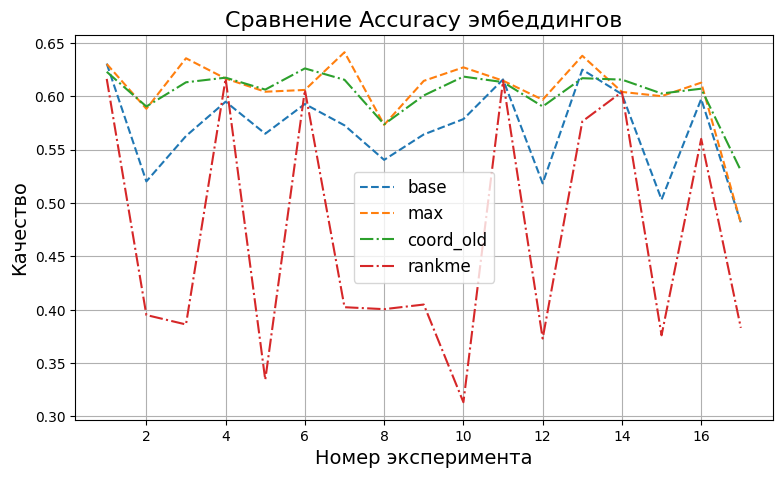

In [ ]:
experiments = np.arange(1, len(coord) + 1)

plt.figure(figsize=(9, 5))


# plt.plot(experiments, coord, color= 'red', label='coord')
plt.plot(experiments, base, linestyle='--', label='base')
plt.plot(experiments, max_, linestyle='--', label='max')
plt.plot(experiments, coord_old, linestyle='-.', label='coord_old')
plt.plot(experiments, rankme_, linestyle='-.', label='rankme')


plt.title(f'Сравнение Accuracy эмбеддингов', fontsize=16)
plt.xlabel('Номер эксперимента', fontsize=14)
plt.ylabel('Качество', fontsize=14)

plt.legend(fontsize=12)

plt.grid(True)

# Показать график
plt.show()

In [ ]:
base1 = np.array(coord_old)

metrics = [
    ('base', base),
    ('max', max_),
    # ('max', max_accs)
]

results = []
for name, metric in metrics:
    diff = (base1 - metric) / metric
    row = {
        'Metric': name,
        'Mean (%)': diff.mean() * 100,      # Относительное изменение в %
        'Std (%)': diff.std() * 100,         # Стандартное отклонение в %
        'Better (%)': (metric < base1).mean() * 100  # Процент случаев
    }
    results.append(row)

# Создание и вывод таблицы
df = pd.DataFrame(results)
df

,Metric,Mean (%),Std (%),Better (%)
0,base,6.518772,5.514498,82.352941
1,max,-0.063806,3.148919,47.058824


In [ ]:
from google.colab import runtime
runtime.unassign()